Original repo:

- https://github.com/anirbankonar123/CorrosionDetector

Forked repo:

- https://github.com/DZDL/CorrosionDetector

In [1]:
!git clone https://github.com/DZDL/CorrosionDetector

Cloning into 'CorrosionDetector'...
remote: Enumerating objects: 322, done.
remote: Total 322 (delta 0), reused 0 (delta 0), pack-reused 322
Receiving objects: 100% (322/322), 33.08 MiB | 24.15 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [2]:
%cd CorrosionDetector

/content/CorrosionDetector


In [3]:
import keras
import tensorflow as tf
from keras.applications import VGG16
from keras.utils.vis_utils import plot_model
import os, shutil
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import models
from keras.preprocessing import image
import numpy as np
import sklearn.metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import seaborn
print(keras.__version__)
print(tf.__version__)

2.4.3
2.4.1


In [4]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

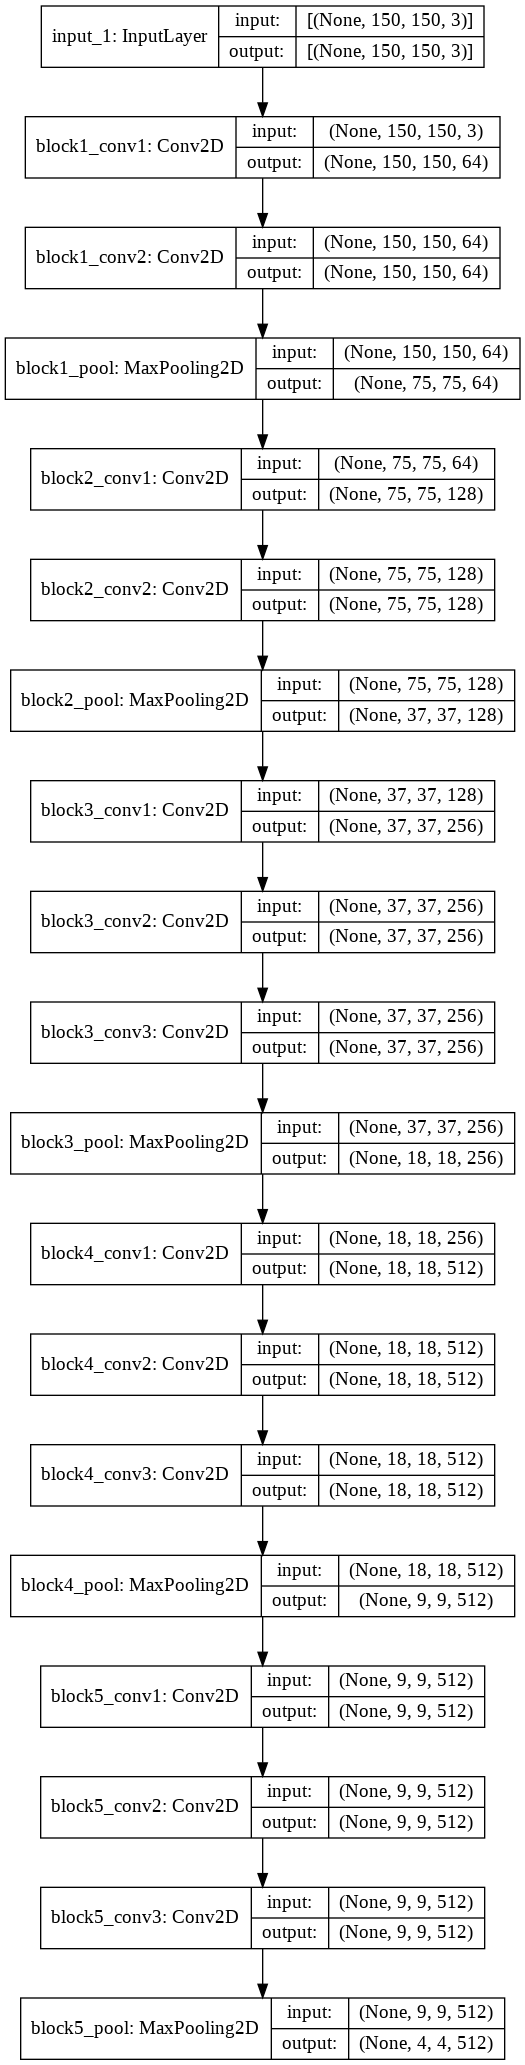

In [6]:
plot_model(conv_base, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
# The path to the directory where the training images are downloaded, change this as in your system
original_dataset_dir = 'download'
original_dataset_dir_rust = 'download/rust'
original_dataset_dir_norust = 'download/norust'

# The directory where we will store our train, test and validation images
base_dir = 'rustnorust_b'


# Directories for our training,validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training rust pictures
train_rust_dir = os.path.join(train_dir, 'rust')

# Directory with our training norust pictures
train_norust_dir = os.path.join(train_dir, 'norust')

# Directory with our validation rust pictures
validation_rust_dir = os.path.join(validation_dir, 'rust')

# Directory with our validation norust pictures
validation_norust_dir = os.path.join(validation_dir, 'norust')

# Directory with our test rust pictures
test_rust_dir = os.path.join(test_dir, 'rust')

# Directory with our test norust pictures
test_norust_dir = os.path.join(test_dir, 'norust')

In [8]:
try:
  os.mkdir(base_dir)
  os.mkdir(train_dir)
  os.mkdir(validation_dir)
  os.mkdir(test_dir)
  os.mkdir(train_rust_dir)
  os.mkdir(train_norust_dir)
  os.mkdir(validation_rust_dir)
  os.mkdir(validation_norust_dir)
  os.mkdir(test_rust_dir)
  os.mkdir(test_norust_dir)
except Exception as e:
  print(e)

In [9]:
# Copy first 70 rust images to train_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(70)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(train_rust_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 5 rust images to validation_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(70, 76)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(validation_rust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 6 rust images to test_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(76, 82)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(test_rust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 60 non-rust images to train_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(60)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(train_norust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 5 norust images to validation_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(60, 66)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(validation_norust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 5 norust images to test_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(63, 72)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(test_norust_dir, fname)
    shutil.copyfile(src, dst)

In [10]:
print('total training rust images:', len(os.listdir(train_rust_dir)))
print('total training norust images:', len(os.listdir(train_norust_dir)))
print('total validation rust images:', len(os.listdir(validation_rust_dir)))
print('total validation norust images:', len(os.listdir(validation_norust_dir)))
print('total test rust images:', len(os.listdir(test_rust_dir)))
print('total test norust images:', len(os.listdir(test_norust_dir)))

total training rust images: 70
total training norust images: 60
total validation rust images: 6
total validation norust images: 6
total test rust images: 6
total test norust images: 9


In [11]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [13]:

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [14]:
conv_base.trainable = False

In [15]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [16]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

 #       save_to_dir='/home/anirban/rustnorust_b/images')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 130 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [18]:
from time import time
from keras.callbacks import TensorBoard
#callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.00001,patience=5,mode='min')]
tensorboard = keras.callbacks.TensorBoard(log_dir='/output/{}'.format(time()))

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])

history = model.fit_generator(train_generator,steps_per_epoch=10,epochs=15,validation_data=validation_generator,validation_steps=20,verbose=2,callbacks=[tensorboard])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
10/10 - 8s - loss: 0.6347 - acc: 0.6579 - val_loss: 0.5441 - val_acc: 0.7500
Epoch 2/15
10/10 - 5s - loss: 0.4825 - acc: 0.7750
Epoch 3/15
10/10 - 5s - loss: 0.4557 - acc: 0.9000
Epoch 4/15
10/10 - 5s - loss: 0.4287 - acc: 0.9250
Epoch 5/15
10/10 - 5s - loss: 0.2982 - acc: 0.9474
Epoch 6/15
10/10 - 5s - loss: 0.3813 - acc: 0.8250
Epoch 7/15
10/10 - 6s - loss: 0.3968 - acc: 0.8750
Epoch 8/15
10/10 - 5s - loss: 0.3565 - acc: 0.8421
Epoch 9/15
10/10 - 5s - loss: 0.2771 - acc: 0.9250
Epoch 10/15
10/10 - 5s - loss: 0.2746 - acc: 0.9250
Epoch 11/15
10/10 - 5s - loss: 0.2655 - acc: 0.9250
Epoch 12/15
10/10 - 6s - loss: 0.3331 - acc: 0.8750
Epoch 13/15
10/10 - 6s - loss: 0.2746 - acc: 0.9250
Epoch 14/15
10/10 - 5s - loss: 0.3126 - acc: 0.8500
Epoch 15/15
10/10 - 5s - loss: 0.1904 - acc: 0.9500


In [19]:
model.save('rustnorust_b/rustnorust_model.h5')

This is a Rust image


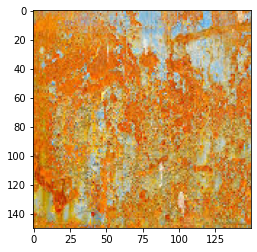

In [22]:
%matplotlib inline
img_path = 'rustnorust_b/test/rust/rust.81.jpg'

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)
test_x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
test_x = test_x.reshape((1,) + test_x.shape)
test_x = test_x.astype('float32') / 255
rust_prob = model.predict(test_x)

if (rust_prob > 0.5):
    print("This is a Rust image")
else:
    print("This is a no Rust image")

This is a no Rust image


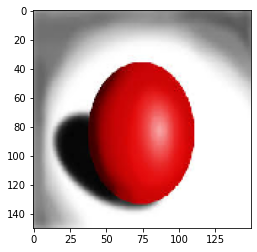

In [23]:
img_path = 'rustnorust_b/test/norust/norust.71.jpg'
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)
test_x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
test_x = test_x.reshape((1,) + test_x.shape)
test_x = test_x.astype('float32') / 255
rust_prob = model.predict(test_x)

if (rust_prob > 0.5):
    print("This is a Rust image")
else:
    print("This is a no Rust image")

In [26]:
os.mkdir('uploadhere')

This is a Rust image


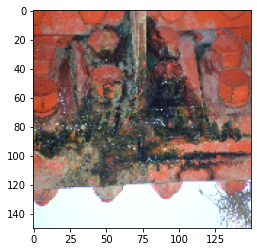

In [29]:
# PATH TO UPLOAD YOUR IMAGE
img_path = 'uploadhere/a.jpg'

img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)
test_x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
test_x = test_x.reshape((1,) + test_x.shape)
test_x = test_x.astype('float32') / 255
rust_prob = model.predict(test_x)

if (rust_prob > 0.5):
    print("This is a Rust image")
else:
    print("This is a no Rust image")